# Temperature Forecast

The goal of this project is to compare performance of two deep learning algorithms on time-series data: Tensorflow's stacked layers of Simple Recurrent Neural Network (RNN) and Long-Short-Term Memory Networks (LSTMs), using MAE and RMSE as evaluation metrics.

Time-series is an ordered sequence of values that are usually equally spaced over time. In our case we are going to generate time-series data that is fairly close to temperature patterns measured over several years in Western Europe.

RNNs is a Neural Network, that contains recurrent layers with the Hidden State, which remembers specific information about a sequence. One could say that RNNs have a "Memory" that stores all information about the calculations. It (Network) employs the same settings for each input since it produces the same outcome by performing the same task on all inputs or hidden layers. 

LSTMs are more complex in their internal architecture than simple RNNs.  LSTM contains both short-term (Hidden State) and long-term (Cell State) memory components to efficiently "learn" sequential data and "forget" unimportant parts of it. This added complexity results in a bigger set of parameters to train and we'll see that when we print the model summary below.

RNNs have quite massively proved their incredible performance in sequence learning. But, it has been remarkably noticed that RNNs are not sporty while handling long-term dependencies.

We'll feed the batches of sequences (temperature values) to RNN and LSTM models and they will output 2 batches of forecasts. 

Let's see which one will predict temperature fluctuations with seasonality and noise better.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time-series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None, model_name='', color=None):
    plt.plot(time[start:end], series[start:end], format, color=color)
    plt.title(f'Generated Time-Series Data Sample {model_name}')
    plt.xlabel("Time(Days)")
    plt.ylabel("Temperatures (°C)")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    # Create arbitrary pattern
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    # Repeate the same pattern at each period
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

All the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope.

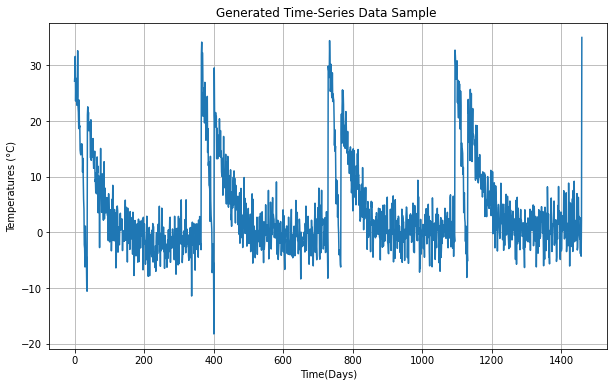

In [3]:
def generate_time_series():
    # Create time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Create initial series values
    y_intercept = -2
    slope = 0.002
    series = trend(time, slope) + y_intercept

    # Add seasonality
    amplitude = 30
    series += seasonality(time, period=365, amplitude=amplitude)

    # Add some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 15
    BATCH_SIZE = 16
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Let's split the data on training and validation sets within `train_val_split` function.


In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

Let's see how our days and temperatures look within sets.

In [5]:
print('First n days, training set:', time_train[:5])
print('Days num., training set:', len(time_train))
print('First n days, validation set:', time_valid[:5])
print('Days num., validation set::', len(time_valid))

First n days, training set: [0. 1. 2. 3. 4.]
Days num., training set: 1100
First n days, validation set: [1100. 1101. 1102. 1103. 1104.]
Days num., validation set:: 361


In [6]:
print('First 5 temperature values, training set:', series_train[:5])
print('Values num., training set:', len(series_train))
print('First 5 values, validation set:', series_valid[:5])
print('Values num., validation set:', len(series_valid))

First 5 temperature values, training set: [27.12849  28.29839  31.59651  23.56401  27.670002]
Values num., training set: 1100
First 5 values, validation set: [30.522633 30.794006 23.27896  27.34175  22.950937]
Values num., validation set: 361


Now we'll slice the temperature values set to create features and labels within it. First `n` values stored within `window_size` will be features and the `window_size + 1` value will be a label, that we would like to predict.

In [7]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Defining the model architecture

Now that we have a function that will process the data before it is fed into our neural network for training, it is time to define the layer architecture for both models. We will use functions `uncompiled_RNN` and `uncompiled_LSTM`, so we can reuse our models' layers for the learning rate adjusting and the actual training.

In [8]:
def uncompiled_LSTM(window_size=G.WINDOW_SIZE):
    
    model = tf.keras.models.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dense(1)
])

    return model

# Print the model summary
lstm = uncompiled_LSTM()
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 15, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 15, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 15, 64)           24832     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

In [9]:
def uncompiled_RNN(window_size=G.WINDOW_SIZE):
  
    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          input_shape=[window_size]),
      tf.keras.layers.SimpleRNN(60, return_sequences=True),
      tf.keras.layers.SimpleRNN(40, return_sequences=True),
      tf.keras.layers.SimpleRNN(40),
      tf.keras.layers.Dense(1)
  ])
    return model

# Print the model summary
rnn = uncompiled_RNN()
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 15, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 15, 60)            3720      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 15, 40)            4040      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 11,041
Trainable params: 11,041
Non-trainable params: 0
_________________________________________________________________


## Adjusting the learning rate

We are going to leverage Tensorflow's callbacks to dynamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better accommodates to the problem at hand. We are going to use this method with this dataset and not hyperparameter optimization to simplify the things a bit, considering we are using synthetic dataset. Callbacks will still give us an idea of what a reasonable learning rate for these models should be.

For the optimizer we are going to use: [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)


In [10]:
def adjust_learning_rate(model):
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 30))
    
    # Instaniate optimizer
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [11]:
# Run the training with dynamic LR
lr_history_lstm = adjust_learning_rate(lstm)

Epoch 1/100
68/68 [==============================] - 12s 38ms/step - loss: 4.7921 - mae: 5.2575 - lr: 1.0000e-05
Epoch 2/100
68/68 [==============================] - 2s 22ms/step - loss: 4.7354 - mae: 5.2009 - lr: 1.0798e-05
Epoch 3/100
68/68 [==============================] - 2s 22ms/step - loss: 4.6665 - mae: 5.1318 - lr: 1.1659e-05
Epoch 4/100
68/68 [==============================] - 2s 22ms/step - loss: 4.5792 - mae: 5.0436 - lr: 1.2589e-05
Epoch 5/100
68/68 [==============================] - 2s 22ms/step - loss: 4.4666 - mae: 4.9289 - lr: 1.3594e-05
Epoch 6/100
68/68 [==============================] - 2s 22ms/step - loss: 4.3287 - mae: 4.7872 - lr: 1.4678e-05
Epoch 7/100
68/68 [==============================] - 2s 22ms/step - loss: 4.1752 - mae: 4.6347 - lr: 1.5849e-05
Epoch 8/100
68/68 [==============================] - 2s 22ms/step - loss: 4.0223 - mae: 4.4853 - lr: 1.7113e-05
Epoch 9/100
68/68 [==============================] - 2s 22ms/step - loss: 3.8942 - mae: 4.3569 - lr: 1.

In [12]:
# Run the training with dynamic LR
lr_history_rnn = adjust_learning_rate(rnn)

Epoch 1/100
68/68 [==============================] - 3s 9ms/step - loss: 4.8917 - mae: 5.3571 - lr: 1.0000e-05
Epoch 2/100
68/68 [==============================] - 1s 8ms/step - loss: 4.8036 - mae: 5.2692 - lr: 1.0798e-05
Epoch 3/100
68/68 [==============================] - 1s 8ms/step - loss: 4.7195 - mae: 5.1844 - lr: 1.1659e-05
Epoch 4/100
68/68 [==============================] - 1s 8ms/step - loss: 4.6329 - mae: 5.0962 - lr: 1.2589e-05
Epoch 5/100
68/68 [==============================] - 1s 8ms/step - loss: 4.5455 - mae: 5.0088 - lr: 1.3594e-05
Epoch 6/100
68/68 [==============================] - 1s 9ms/step - loss: 4.4657 - mae: 4.9283 - lr: 1.4678e-05
Epoch 7/100
68/68 [==============================] - 1s 8ms/step - loss: 4.4011 - mae: 4.8647 - lr: 1.5849e-05
Epoch 8/100
68/68 [==============================] - 1s 8ms/step - loss: 4.3437 - mae: 4.8090 - lr: 1.7113e-05
Epoch 9/100
68/68 [==============================] - 1s 8ms/step - loss: 4.2912 - mae: 4.7580 - lr: 1.8478e-05
E

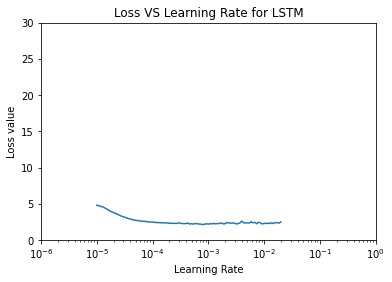

In [13]:
# Plot the loss for every LR
def draw_loss(lr_history, model_name):
    plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
    plt.axis([1e-6, 1, 0, 30])
    plt.title(f'Loss VS Learning Rate for {model_name}')
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss value")
    return 

draw_loss(lr_history_lstm, 'LSTM')

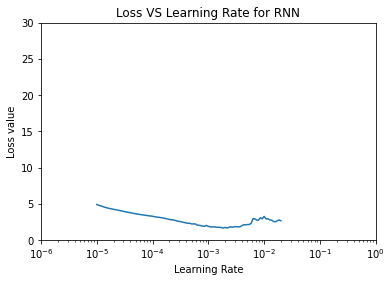

In [14]:
draw_loss(lr_history_rnn, 'RNN')

## Compiling the model

Now that we have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. We will use the optimal learning rates that we've extracted from the previus step.

In [15]:
def create_model(model, learning_rate):

    tf.random.set_seed(51)

    # Set the optimizer 
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Set the training parameters
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    return model

In [16]:
# Save an instance of the model
compiled_lstm = create_model(lstm, 0.0015)

# Train it
history = compiled_lstm.fit(dataset, epochs=50)

Epoch 1/50
68/68 [==============================] - 11s 24ms/step - loss: 2.2879 - mae: 2.7466
Epoch 2/50
68/68 [==============================] - 2s 23ms/step - loss: 2.2075 - mae: 2.6617
Epoch 3/50
68/68 [==============================] - 2s 23ms/step - loss: 2.1471 - mae: 2.5954
Epoch 4/50
68/68 [==============================] - 2s 23ms/step - loss: 2.1000 - mae: 2.5461
Epoch 5/50
68/68 [==============================] - 2s 23ms/step - loss: 2.0755 - mae: 2.5242
Epoch 6/50
68/68 [==============================] - 2s 23ms/step - loss: 2.0304 - mae: 2.4754
Epoch 7/50
68/68 [==============================] - 2s 24ms/step - loss: 2.0130 - mae: 2.4552
Epoch 8/50
68/68 [==============================] - 2s 24ms/step - loss: 2.0038 - mae: 2.4415
Epoch 9/50
68/68 [==============================] - 2s 23ms/step - loss: 1.9732 - mae: 2.4131
Epoch 10/50
68/68 [==============================] - 2s 23ms/step - loss: 1.9523 - mae: 2.3873
Epoch 11/50
68/68 [==============================] - 2s 24

In [17]:
# Save an instance of the model
compiled_rnn = create_model(rnn, 0.0011)

# Train it
history = compiled_rnn.fit(dataset, epochs=50)

Epoch 1/50
68/68 [==============================] - 3s 9ms/step - loss: 2.4454 - mae: 2.9031
Epoch 2/50
68/68 [==============================] - 1s 9ms/step - loss: 2.3512 - mae: 2.8040
Epoch 3/50
68/68 [==============================] - 1s 9ms/step - loss: 2.3236 - mae: 2.7792
Epoch 4/50
68/68 [==============================] - 1s 9ms/step - loss: 2.3079 - mae: 2.7611
Epoch 5/50
68/68 [==============================] - 1s 9ms/step - loss: 2.2932 - mae: 2.7465
Epoch 6/50
68/68 [==============================] - 1s 9ms/step - loss: 2.2981 - mae: 2.7529
Epoch 7/50
68/68 [==============================] - 1s 9ms/step - loss: 2.2797 - mae: 2.7346
Epoch 8/50
68/68 [==============================] - 1s 9ms/step - loss: 2.2421 - mae: 2.6937
Epoch 9/50
68/68 [==============================] - 1s 9ms/step - loss: 2.2553 - mae: 2.7110
Epoch 10/50
68/68 [==============================] - 1s 9ms/step - loss: 2.2321 - mae: 2.6842
Epoch 11/50
68/68 [==============================] - 1s 9ms/step - lo

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast.

In [18]:
def compute_metrics(true_series, forecast):
    
    rmse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy() ** 0.5
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return rmse, mae

At this point only the models that will perform the forecast are ready but we still need to compute the actual forecast. 

## Compare models' forecasts

We will use batches of data to compute the forecasts for every point in the sequence.

In [19]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

46/46 [==============================] - 3s 8ms/step


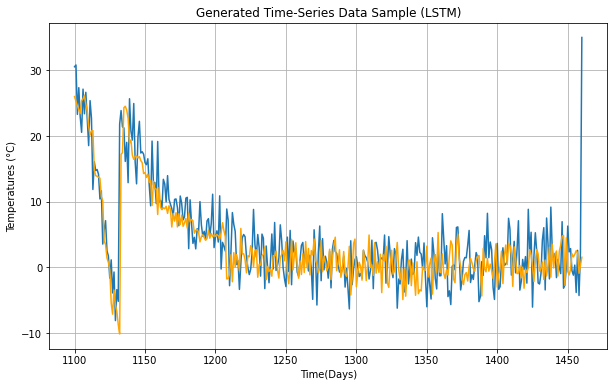

In [20]:
# Compute the forecast for all the series
lstm_forecast = model_forecast(compiled_lstm, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
lstm_forecast = lstm_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, lstm_forecast, model_name='(LSTM)', color='orange')

46/46 [==============================] - 1s 4ms/step


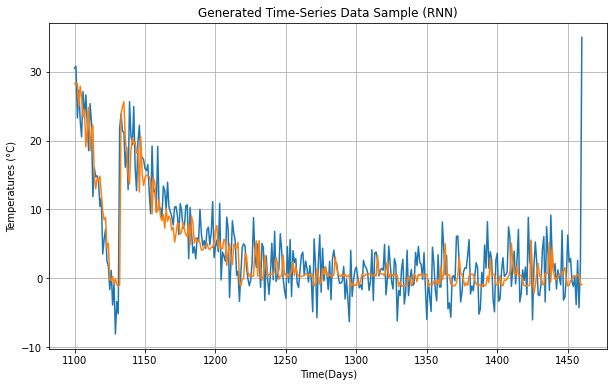

In [21]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(compiled_rnn, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast, model_name='(RNN)')

In [22]:
rmse, mae = compute_metrics(series_valid, lstm_forecast)

print(f"rmse: {rmse:.2f}, mae: {mae:.2f}, using LSTM")

rmse: 4.64, mae: 3.28, using LSTM


In [23]:
rmse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"rmse: {rmse:.2f}, mae: {mae:.2f}, using RNN")

rmse: 4.28, mae: 3.06, using RNN


## Conclusion 

We have successfully implemented 2 models capable of forecasting synteticaly generated time-series data, using `RNNs` and `LSTMs` layers.

After tuning such parameters as `batch_size`, `window_size`, `learning_rate` and experimenting with number of layers and neurons in the networks we have came to fairly low error values `rmse` - **~4.5** and `mae` - **~3**, for LSTM and RNN. 

LSTM model has managed to surpass the RNN model in some configurations, but not most of them and not by much. It will be fair to say that both models perform quite good when it comes to seasonal temperature prediction.